In [1]:
### Imports
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
from pandas import DataFrame
import plotly.express as px
import plotly
import numpy as np

np.random.seed(1991)

In [60]:
from pathlib import Path

### Paths
data_path = Path('').parent.absolute()

paper_annotations_path = data_path / 'analysis/manual_papers_coding.csv'
patent_annotations_path = data_path / 'analysis/manual_patents_coding.csv'
(figs_dir := data_path / 'figures').mkdir(exist_ok=True)


### Parameter
doc_type = 'all'  # Can be paper, patent, or all. Only this slice of the date will be used to calculate the pie chart

### Load and clean data
# Load
papers = pd.read_csv(paper_annotations_path)
papers['Doc_type'] = 'paper'
patents = pd.read_csv(patent_annotations_path)
patents['Doc_type'] = 'patent'
papers_and_patents = pd.concat([papers, patents], ignore_index=True)  # combine papers and patents
docs = dict(paper=papers, patent=patents, all=papers_and_patents)[doc_type]

# Clean
docs = docs.replace({
    'Traces of socially significant human data (e.g. location, friends, cultural identity, preferences)': 'Salient traces',
    'Traces of human data (e.g. an engineer\'s blueprints)': 'Unspecified',
    'Unspecified data (provides no indication of applications)': 'Unspecified',
    'Unspecified data (does not state whether can be used for human data)': 'Unspecified'})
data = docs.copy()
data['Data'] = data['label']
categories = data['Data'].unique().tolist()

In [61]:
# compute percentages
percentages = data['label'].value_counts(normalize=True)
percentages = percentages.to_dict()

In [62]:
# now compute standard deviations; we will use bootstrapping over k samples (k=1000)
# to get a distribution of the percentages
import collections

labels_map = {k: i for i, k in enumerate(percentages.keys())}
reverse_labels_map = {v: k for k, v in labels_map.items()}
labels_to_sample = np.array([labels_map[l] for l in data['label'].tolist()])

# now sample 1000 times with replacement
k = 1000

samples_labels = {}

for _ in range(k):
    sample = np.random.choice(labels_to_sample, len(labels_to_sample), replace=True)
    counts = collections.Counter(sample)
    for k, v in counts.items():
        if k not in samples_labels:
            samples_labels[k] = []
        samples_labels[k].append(v / len(sample))

print('Total annotations:', len(data))
for l, v in sorted(percentages.items(), key=lambda x: -x[1]):
    k = labels_map[l]
    print (f'{l}:\t{v * 100:.1f}±{np.std(samples_labels[k]):.1%}')

Total annotations: 200
Human bodies:	37.0±3.3%
Human body parts:	31.0±3.2%
Human spaces:	17.0±2.6%
Unspecified:	11.0±2.2%
Salient traces:	3.0±1.2%
Non-human data:	1.0±0.6%


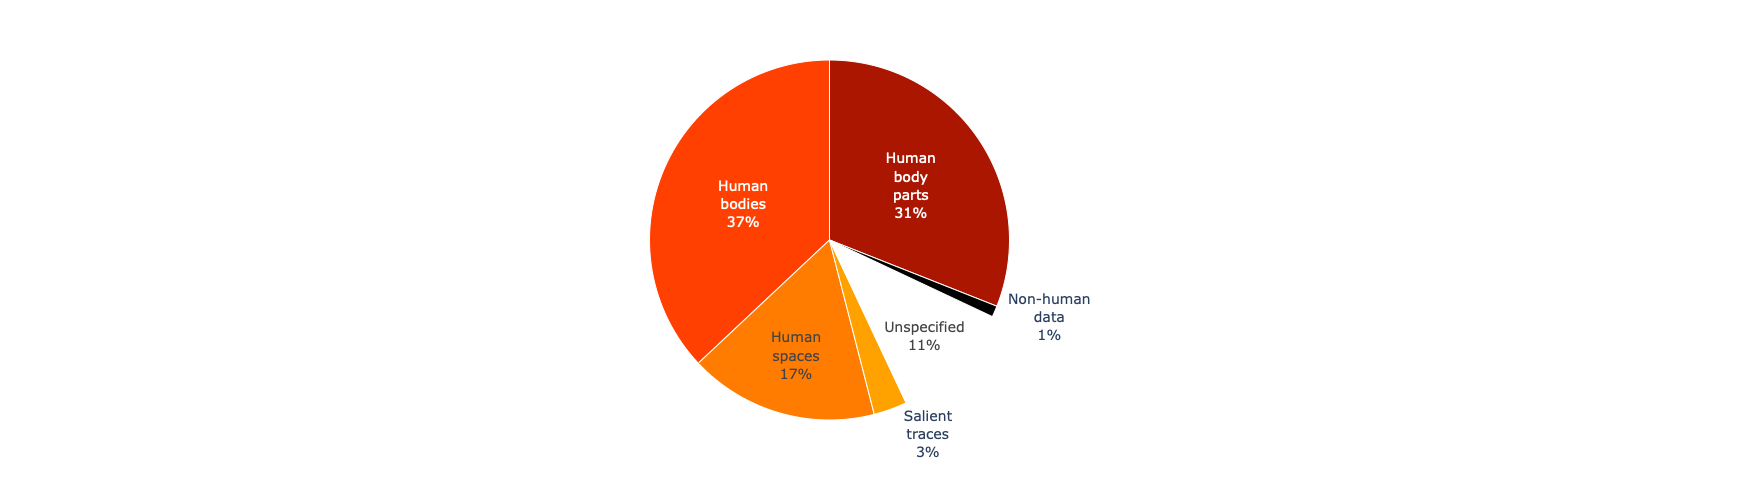

In [63]:
### Visualize pie chart
labels = ['Human body parts', 'Human bodies', 'Human spaces', 'Salient traces', 'Unspecified', 'Non-human data']  # in desired order for visualization
pretty_labels = list(map(lambda l: l.replace(' ', '<br>'), labels))
fig = px.pie(
    names=pretty_labels, values=[percentages[label] for label in labels], 
    width=500, height=500, color_discrete_sequence=['#AA1600', '#FF4000', '#FF7C00', '#FFA200'] + ['white', 'black'])
fig.update_layout(showlegend=False, font_size=15, paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
fig.update_traces(textinfo='percent+label', rotation=0, insidetextorientation='horizontal', textfont_size=14, sort=False, marker=dict(line=dict(color='white', width=1)))
plotly.io.write_image(fig, os.path.join(figs_dir, f'pie.png'),scale=10)
fig